# Setup

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import random
import time
from tqdm.notebook import tqdm_notebook

tqdm_notebook.pandas()

In [10]:
exec_time_path = '/home/sylli/Documents/MSAD-E/data/results_from_MSAD/detectors_inference_time.csv'
csv_dir = '/home/sylli/Documents/MSAD-E/reports/results_06_2024'
save_fig_path = os.path.join(csv_dir, "figures")

In [4]:
# Detectors
detector_names = [
	'AE', 
	'CNN', 
	'HBOS', 
	'IFOREST', 
	'IFOREST1', 
	'LOF', 
	'LSTM', 
	'MP', 
	'NORMA', 
	'OCSVM', 
	'PCA', 
	'POLY'
]

weight_names = [f"weight_{x}" for x in detector_names]

model_selectors = [
    "convnet128",
    "resnet1024",
    "sit512",
    "knn1024",
]

combine_methods = ['average', 'vote']

datasets = [
    'MGAB', 
    'GHL', 
    'MITDB', 
    'Genesis', 
    'OPPORTUNITY', 
    'SensorScope', 
    'KDD21', 
    'Occupancy', 
    'SVDB', 
    'IOPS', 
    'SMD', 
    'Daphnet',
    'ECG',
    'NAB',
    'YAHOO'
]

metrics = ['AUC-ROC', 'AUC-PR', 'VUS-ROC', 'VUS-PR']

k_values = np.arange(1, 13)

In [5]:
def load_results(csv_file):
    """Load results from a CSV file."""
    return pd.read_csv(csv_file, index_col=0)

# Load data

In [6]:
# Read files
result_files = [file for file in os.listdir(csv_dir) if file.endswith('.csv')]
print(np.random.choice(result_files, 3))

supervised_files = [file for file in result_files if "testsize" not in file]
unsupervised_files = [file for file in result_files if "testsize" in file]
print((f"Total number of files {len(result_files)}, of which {len(supervised_files)} "
        f"supervised and {len(unsupervised_files)} ({len(supervised_files)} + "
        f"{len(unsupervised_files)} = {len(supervised_files) + len(unsupervised_files)})"))

['SMD_knn1024_vote_k12.csv' 'Daphnet_sit512_vote_k5.csv'
 'SMD_sit512_average_k3.csv']
Total number of files 2976, of which 1440 supervised and 1536 (1440 + 1536 = 2976)


In [7]:
# Load data
all_results = []
curr_experiment_env = set()

for file in supervised_files:
    parts = file.split('_')

    if len(parts) != 4:
        print("STOP! THERE IS A MISTAKE WITH GROUPING THE FILES. FILE NAME HAS PROBABLY CHANGED. TAKE CARE")
    else:
        dataset = parts[0]
        model_selector = parts[1]
        combine_method = parts[-2]
        k = int(parts[-1].split('.')[0][1:])
        if (dataset not in datasets) or \
        (model_selector not in model_selectors) or \
        (combine_method not in combine_methods) or \
        (k not in k_values):
            print("STOP! THERE IS A MISTAKE WITH GROUPING THE FILES. FILE NAME HAS PROBABLY CHANGED. TAKE CARE")
            break
        else:
            curr_df = pd.read_csv(os.path.join(csv_dir, file))
            curr_df.rename(columns={'Unnamed: 0': 'Time series'}, inplace=True)
            curr_df['Model Selector'] = model_selector
            curr_df['k'] = k
            curr_df['Combine Method'] = combine_method
            curr_df['Dataset'] = dataset
            all_results.append(curr_df)

            # Update curr existing datasets, MSs, etc.
            curr_experiment_env.add(dataset)
            curr_experiment_env.add(model_selector)
            curr_experiment_env.add(combine_method)
            curr_experiment_env.add(k)

df = pd.concat(all_results)
df

,Time series,AUC-ROC,AUC-PR,VUS-ROC,VUS-PR,weight_AE,weight_CNN,weight_HBOS,weight_IFOREST,weight_IFOREST1,...,weight_LSTM,weight_MP,weight_NORMA,weight_OCSVM,weight_PCA,weight_POLY,Model Selector,k,Combine Method,Dataset
0,OPPORTUNITY/S4-ADL2.test.csv@120.out,0.988037,0.727534,0.988884,0.668741,0.000000,0.0,0.371585,0.245902,0.262295,...,0.000000,0.120219,0.000000,0.000000,0.000000,0.000000,convnet128,4,vote,OPPORTUNITY
1,OPPORTUNITY/S4-ADL5.test.csv@54.out,0.875665,0.441889,0.873274,0.426190,0.097222,0.0,0.000000,0.000000,0.000000,...,0.000000,0.060185,0.777778,0.000000,0.064815,0.000000,convnet128,4,vote,OPPORTUNITY
2,OPPORTUNITY/S1-ADL2.test.csv@103.out,0.976011,0.905340,0.976931,0.910039,0.000000,0.0,0.253521,0.122066,0.000000,...,0.000000,0.248826,0.000000,0.000000,0.375587,0.000000,convnet128,4,vote,OPPORTUNITY
3,OPPORTUNITY/S2-ADL1.test.csv@124.out,0.959100,0.380968,0.959369,0.374407,0.000000,0.0,0.291946,0.429530,0.000000,...,0.000000,0.000000,0.124161,0.000000,0.000000,0.000000,convnet128,4,vote,OPPORTUNITY
4,OPPORTUNITY/S4-ADL3.test.csv@53.out,0.714998,0.088627,0.713218,0.087893,0.174419,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.546512,0.000000,0.104651,0.000000,convnet128,4,vote,OPPORTUNITY
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32,GHL/14_Lev_fault_Temp_corr_seed_47_vars_23.tes...,0.926481,0.006934,0.923850,0.005955,0.000000,0.0,0.645553,0.019834,0.041587,...,0.002559,0.216251,0.000000,0.071657,0.000000,0.000000,convnet128,9,vote,GHL
33,GHL/10_Lev_fault_Temp_corr_seed_39_vars_23.tes...,0.964423,0.009649,0.958804,0.007605,0.000000,0.0,0.653231,0.021753,0.023672,...,0.006398,0.227767,0.000000,0.062060,0.000000,0.000000,convnet128,9,vote,GHL
34,GHL/04_Lev_fault_Temp_corr_seed_23_vars_23.tes...,0.527898,0.000803,0.527781,0.000774,0.000000,0.0,0.445937,0.022393,0.024312,...,0.000000,0.433781,0.000000,0.044146,0.000640,0.001919,convnet128,9,vote,GHL
35,GHL/37_Lev_corr_Temp_fault_seed_163_vars_23.te...,0.923395,0.121603,0.788088,0.038154,0.000000,0.0,0.470889,0.000000,0.107486,...,0.000000,0.420985,0.000000,0.000000,0.000000,0.000640,convnet128,9,vote,GHL


In [8]:
# Update available parameters depending on read data
datasets = [x for x in datasets if x in curr_experiment_env]
model_selectors = [x for x in model_selectors if x in curr_experiment_env]
combine_methods = [x for x in combine_methods if x in curr_experiment_env]
k_values = [x for x in k_values if x in curr_experiment_env]

In [11]:
# Read execution time per detector, per time series
time_df = pd.read_csv(exec_time_path)
time_df['filename'] = time_df.apply(lambda x: f"{x['dataset']}/{x['filename']}", axis='columns')
time_df.rename(columns={'filename': 'Time series', 'dataset': 'Dataset'}, inplace=True)
time_df.set_index('Time series', inplace=True)

# Keep time series that are in the final validation set 
df = df[df['Time series'].isin(time_df.index)].copy()

In [12]:
def compute_execution_time(elem, time_df, detector_names, weight_names):
    non_zero_columns = elem[weight_names][elem[weight_names] != 0].index
    detectors_used = [x.replace('weight_', '') for x in non_zero_columns]

    return np.sum(time_df.loc[elem['Time series'], detectors_used])

In [13]:
df['Execution Time'] = df.progress_apply(lambda x: compute_execution_time(x, time_df, detector_names, weight_names), axis=1)

  0%|          | 0/47616 [00:00<?, ?it/s]

In [14]:
df["k_real"] = np.sum(df.filter(like="weight_") != 0, axis=1)

# Analysis

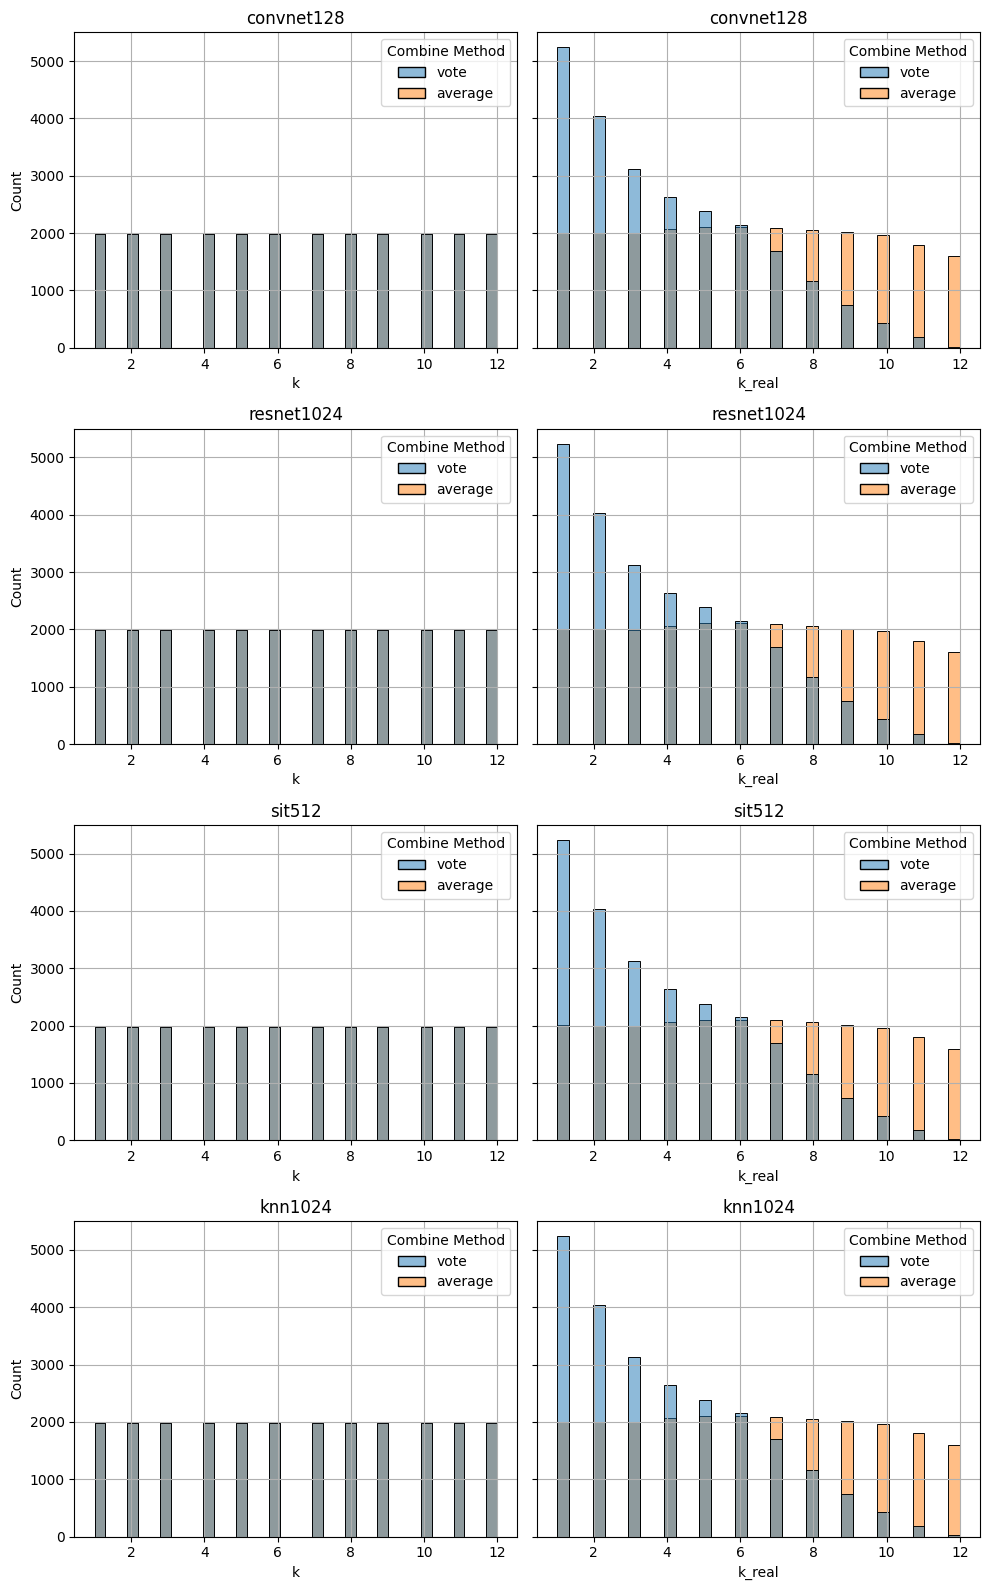

In [15]:
# k Distribution
fig, axes = plt.subplots(4, 2, figsize=(10, 16), sharey=True)

for i, model_selector in enumerate(model_selectors):    
    sns.histplot(ax=axes[i, 0], data=df, x='k', hue='Combine Method')
    sns.histplot(ax=axes[i, 1], data=df, x='k_real', hue='Combine Method')

    
    axes[i, 0].set_title(model_selector)
    axes[i, 1].set_title(model_selector)
    
for ax in axes.flatten():
    ax.grid()

plt.tight_layout()
plt.show()

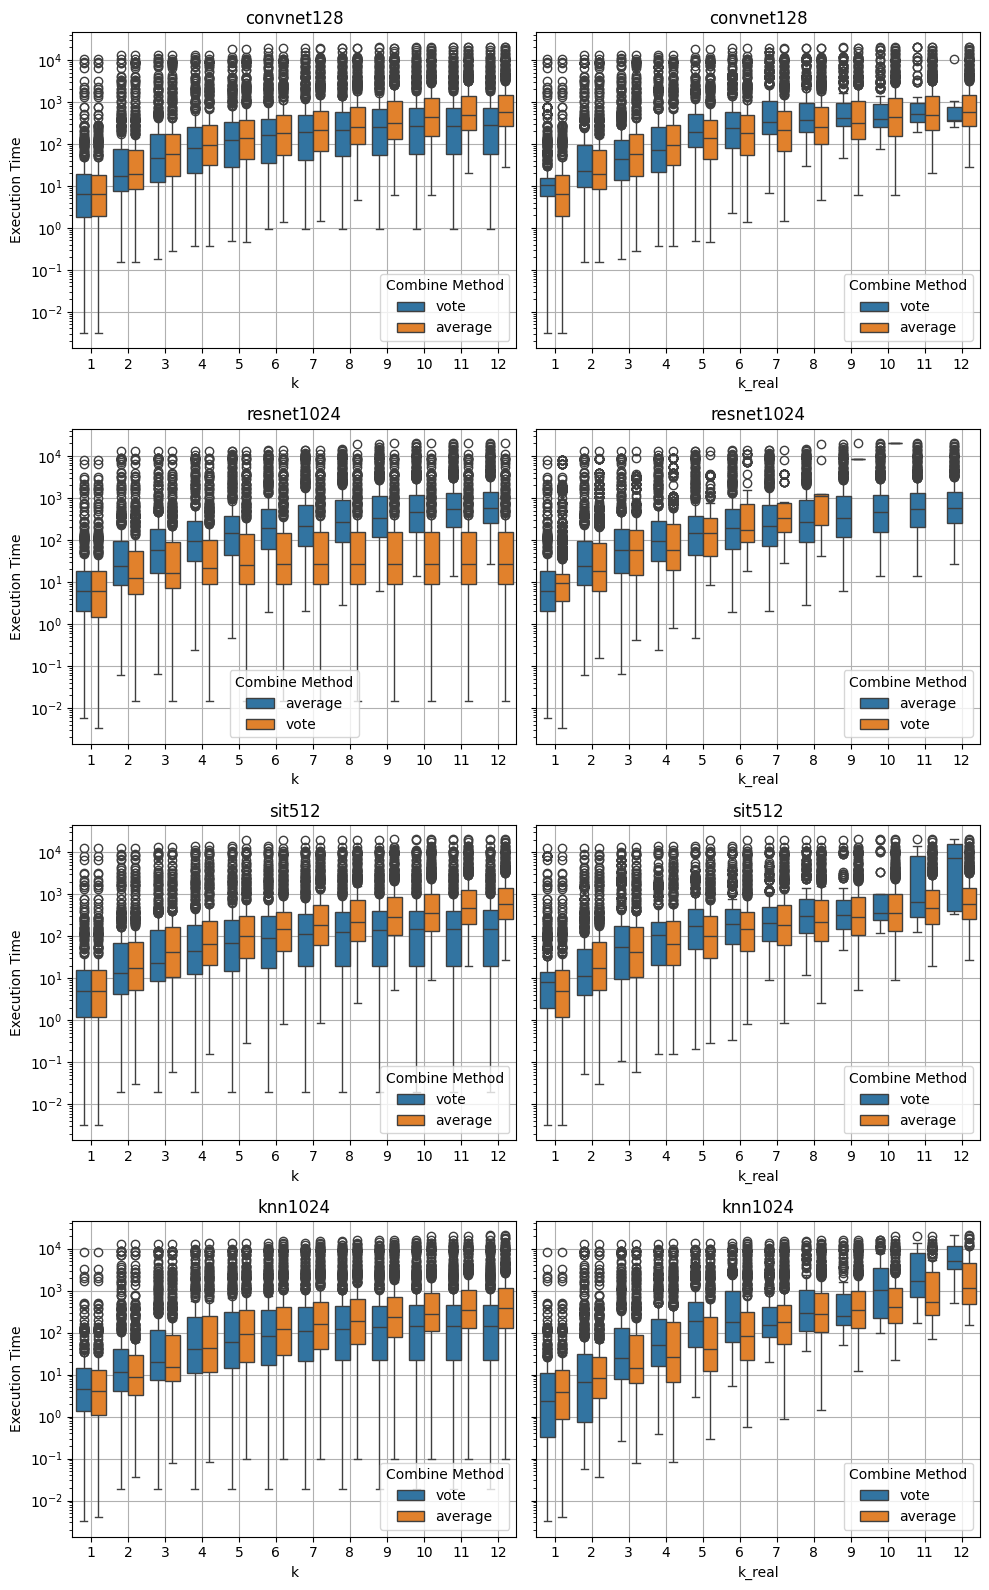

In [16]:
# Execution Time
fig, axes = plt.subplots(4, 2, figsize=(10, 16), sharey=True)

for i, model_selector in enumerate(model_selectors):    
    sns.boxplot(ax=axes[i, 0], data=df[df['Model Selector'] == model_selector], x='k', y='Execution Time', hue='Combine Method')
    sns.boxplot(ax=axes[i, 1], data=df[df['Model Selector'] == model_selector], x='k_real', y='Execution Time', hue='Combine Method')
    
    axes[i, 0].set_title(model_selector)
    axes[i, 1].set_title(model_selector)
    
for ax in axes.flatten():
    ax.set_yscale('log')
    ax.grid()

plt.tight_layout()
plt.show()

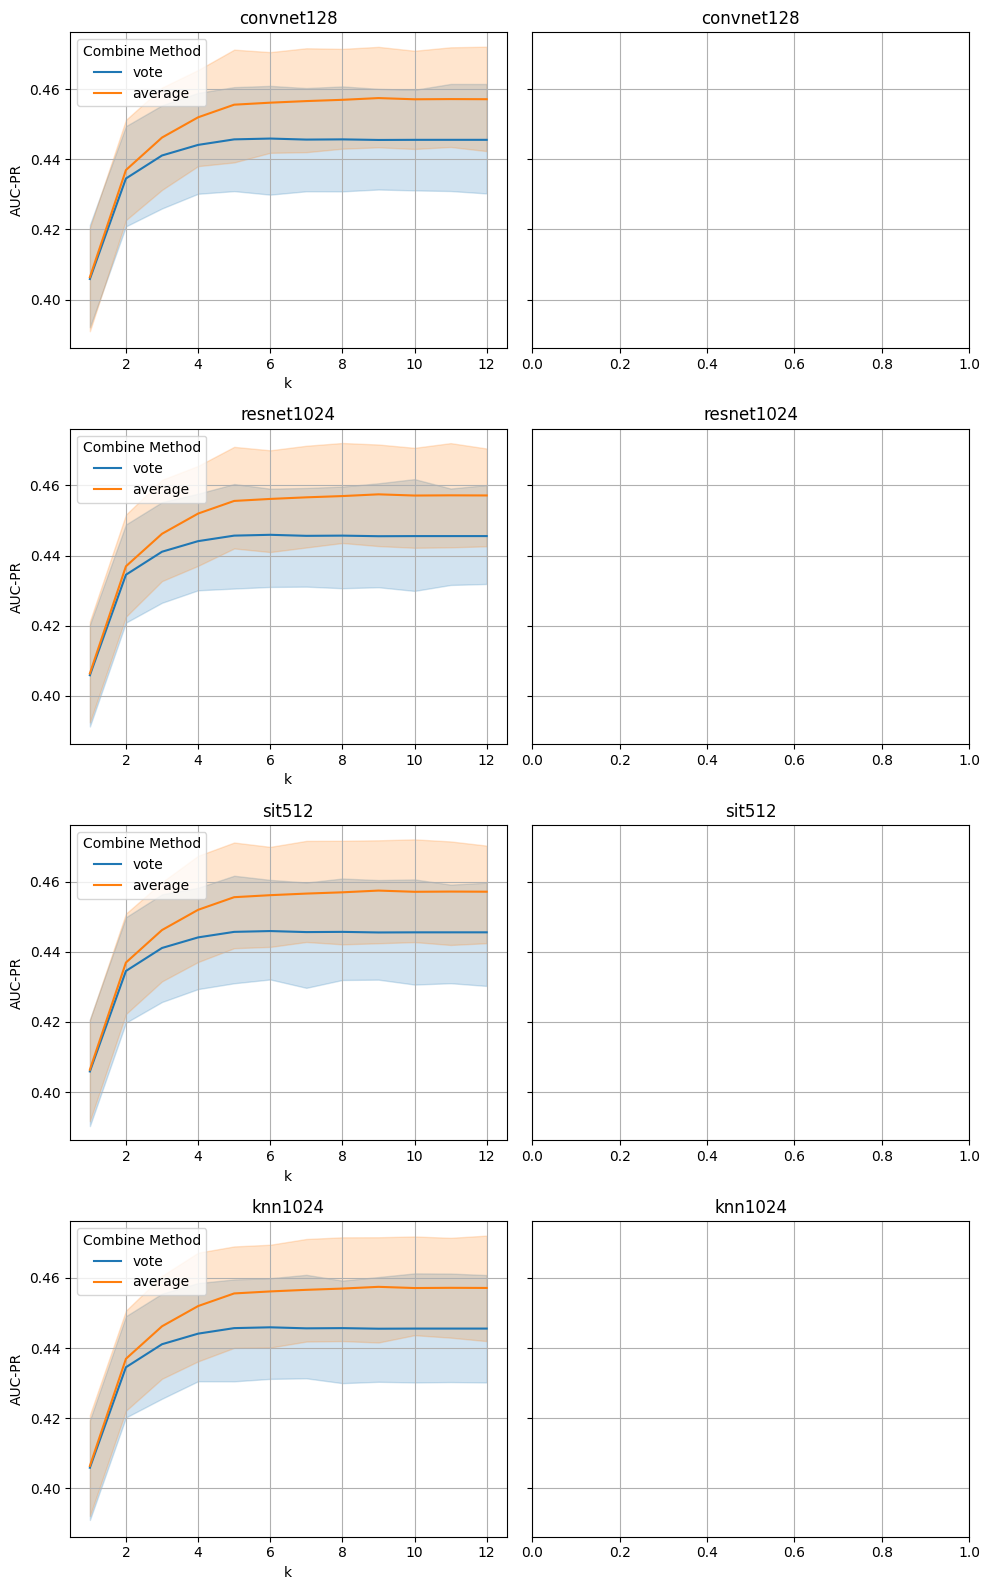

In [17]:
# Execution Time
fig, axes = plt.subplots(4, 2, figsize=(10, 16), sharey=True)

for i, model_selector in enumerate(model_selectors):    
    sns.lineplot(ax=axes[i, 0], data=df, x='k', y='AUC-PR', hue='Combine Method')
    # sns.lineplot(ax=axes[i, 1], data=df, x='k_real', y='AUC-PR', hue='Combine Method')
    
    axes[i, 0].set_title(model_selector)
    axes[i, 1].set_title(model_selector)
    
for ax in axes.flatten():
    ax.grid()

plt.tight_layout()
plt.show()

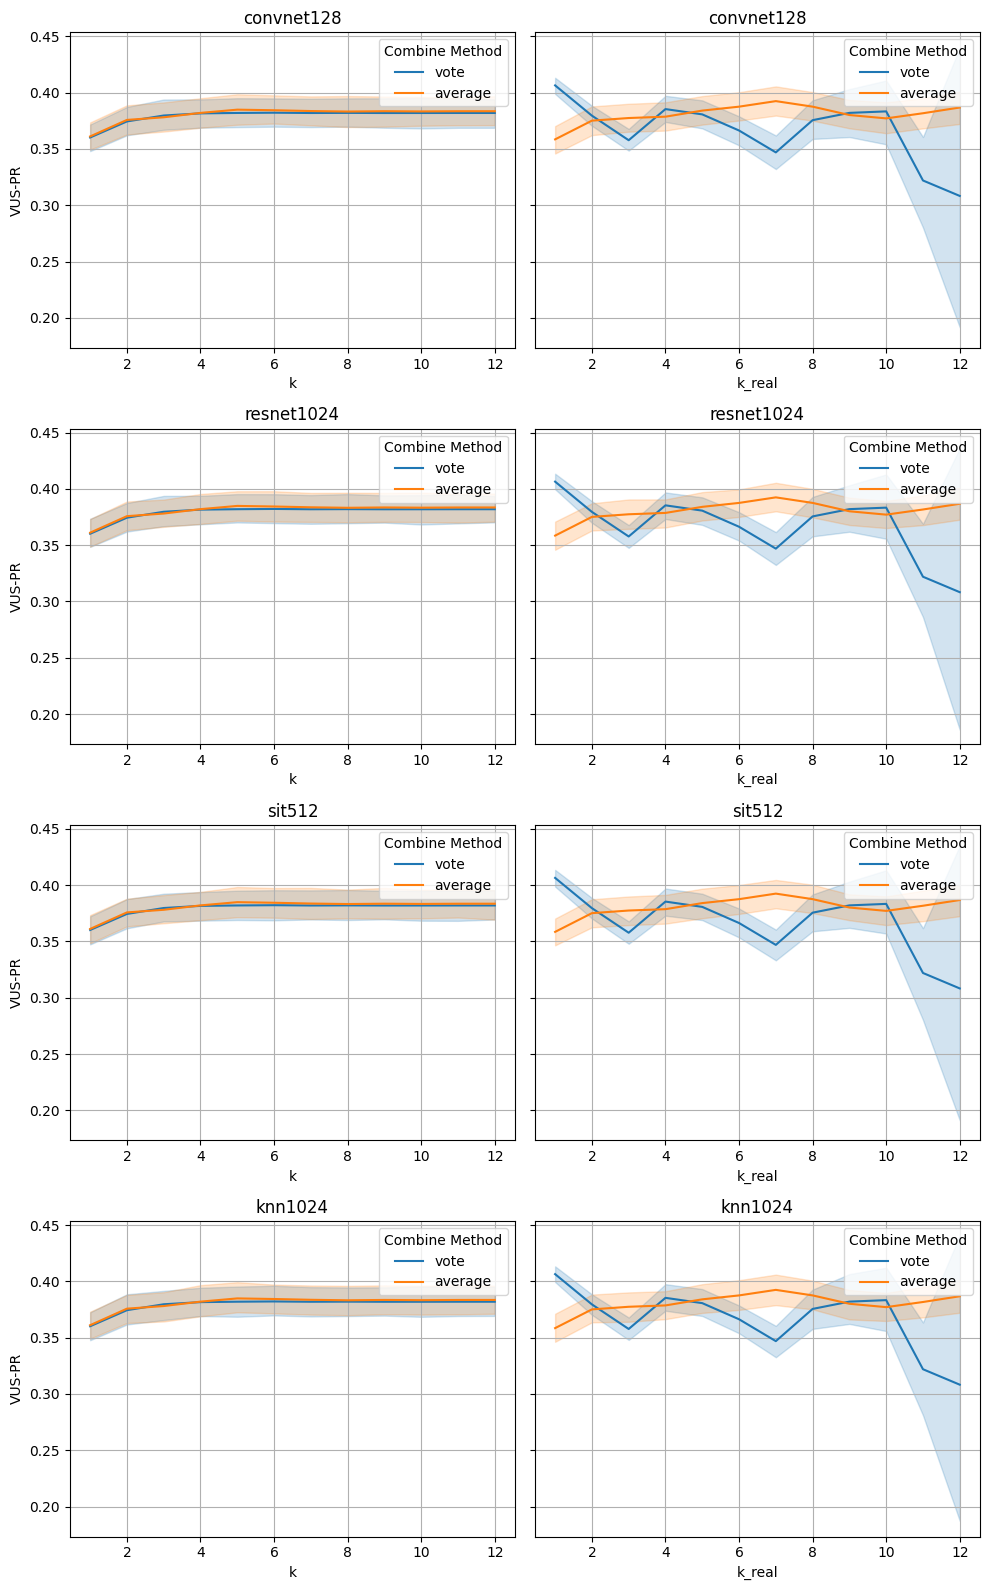

In [18]:
# Execution Time
fig, axes = plt.subplots(4, 2, figsize=(10, 16), sharey=True)

for i, model_selector in enumerate(model_selectors):    
    sns.lineplot(ax=axes[i, 0], data=df, x='k', y='VUS-PR', hue='Combine Method')
    sns.lineplot(ax=axes[i, 1], data=df, x='k_real', y='VUS-PR', hue='Combine Method')
    
    axes[i, 0].set_title(model_selector)
    axes[i, 1].set_title(model_selector)
    
for ax in axes.flatten():
    ax.grid()

plt.tight_layout()
plt.show()